# **Predicting Movie Rental Durations**





A DVD rental company needs my help! (Oh I'm flattered). They want to figure out how many days a customer will rent a DVD for, based on some features and has approached me for help. They want me to try out some regression models which will help predict the number of days a customer will rent a DVD for.

The company wants a model which yeilds a MSE of 3 or less on a test set. The model that'd be made should help the company become more efficient in inventory planning.





> **_Note_**: This project is adapted from guided projects on DataCamp, completed as part of my coursework for the **Machine Learning Scientist with Python certification**. The work presented here represents an extended and applied interpretation of those foundational materials.

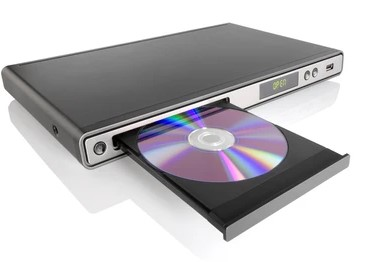

The data they provided is in the csv file `rental_info.csv`, and has the following features:


- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise.

For my convenience, the reference dummy was dropped. Essentially, the data is cleaned and near ready for modelling.

In [38]:
# Import pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# TTS fucntion to split data and MSE to measure model perfoemance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# For OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# For Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# For xgb model
import xgboost as xgb

In [4]:
# Read in data
df_rental = pd.read_csv("rental_info.csv")

# view head
df_rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [5]:
# info
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [8]:
# select numeric data
numeric_df = df_rental.select_dtypes(include=[np.float64])

# select numeric for flaot


# view head
numeric_df.describe()

,amount,release_year,rental_rate,length,replacement_cost,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,143.760100,34225.000000,24.900100


**Amount**: Average renting amount is 4.22 dollars, with min and max: 0.99 and 11.99. The mean is greater than Median 3.99, therefore the amount distribution is rightly skewed.

**Rental rate**  is slighly left skewed with mean and median value value: 2.94 and 2.99.  

The company rents circa 3 DVDs at 4.21 dollars each on average.



In [6]:
# Add information on rental duration
df_rental["rental_length"] = pd.to_datetime(df_rental["return_date"]) - pd.to_datetime(df_rental["rental_date"])
df_rental["rental_length_days"] = df_rental["rental_length"].dt.days

In [9]:
## Add dummy variables
# Add dummy for deleted scenes
df_rental["deleted_scenes"] =  np.where(df_rental["special_features"].str.contains("Deleted Scenes"), 1, 0)
# Add dummy for behind the scenes
df_rental["behind_the_scenes"] =  np.where(df_rental["special_features"].str.contains("Behind the Scenes"), 1, 0)

# Choose columns to drop
cols_to_drop = ["special_features", "rental_length", "rental_length_days", "rental_date", "return_date"]

In [10]:
# Split into feature and target sets
X = df_rental.drop(cols_to_drop, axis=1)
y = df_rental["rental_length_days"]

# Further split into training and test data
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=75)

In [51]:
# Create the Lasso model
lasso = Lasso(alpha=0.3, random_state= 75)

# Train the model and access the coefficients
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_


# Select columns with non-zero Lasso coefficients
mask = lasso_coef != 0
X_lasso_train, X_lasso_test = X_train.loc[:, mask], X_test.loc[:, mask]

# print columns
print(X_train.columns, '\n')
print(f'\nTake a look at selected columns:\n')
print(X_lasso_train.columns)

Index(['amount', 'release_year', 'rental_rate', 'length', 'replacement_cost',
       'NC-17', 'PG', 'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2',
       'deleted_scenes', 'behind_the_scenes'],
      dtype='object') 


Take a lokk at selected columns:

Index(['amount', 'amount_2', 'length_2', 'rental_rate_2'], dtype='object')


In [24]:
# Run OLS models on lasso chosen regression
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

In [40]:
# Random forest hyperparameter space
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

# Create a random forest regressor
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rf_rand_search = RandomizedSearchCV(rf,
                                 param_distributions= param_dist,
                                 cv= 10,
                                 random_state= 75)

# Fit the random search object to the data
rf_rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = rf_rand_search.best_params_

# print paramters of optimal model
#rand_search.best_params_

for key, value in hyper_params.items():
    print(f"{key}: {value}")

rf_rand_search.fit(X_train,y_train)
rf_pred = rf_rand_search.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

n_estimators: 61
max_depth: 10


In [39]:
# xgb boost hyperparameter space
param_dist = {'max_depth': np.arange(1, 11, 1),
              'n_estimators': np.arange(1, 101, 1)}

# Create a random forest regressor
xgb_model = xgb.XGBRegressor()

# Use random search to find the best hyperparameters
xgb_rand_search = RandomizedSearchCV(xgb_model,
                                 param_distributions= param_dist,
                                 cv= 10,
                                 random_state= 75)

# Fit xgb random search object
xgb_rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = xgb_rand_search.best_params_

# print paramters of optimal model
#rand_search.best_params_

for key, value in hyper_params.items():
    print(f"{key}: {value}")

xgb_rand_search.fit(X_train,y_train)
xgb_pred = xgb_rand_search.predict(X_test)
mse_xgb= mean_squared_error(y_test, xgb_pred)

n_estimators: 50
max_depth: 9


In [41]:
xgb.XGBRegressor?

In [48]:
# Create dictionary for all mse
mse_dict = {"ols_lasso": mse_lin_reg_lasso,
            "random_forest": mse_random_forest,
            "xgb": mse_xgb}

# loop and print each mse
for key, value in mse_dict.items():
    print(f"{key}: {value}")

# select best mse
best_mse = min(mse_dict.values())

# print best mse with name
for key, value in mse_dict.items():
    if value == best_mse:
        print(f"\nThe best model is {key} with a MSE of {value:.4f}")

ols_lasso: 2.986574631314964
random_forest: 2.1848754883047024
xgb: 1.952956199645996

The best model is xgb with a MSE of 1.9530


In [49]:
# compute rmse
rmse_dict = {}
for key, value in mse_dict.items():
    rmse_dict[key] = np.sqrt(value)

# print best
best_rmse = min(rmse_dict.values())

# print best mse with name
for key, value in rmse_dict.items():
    if value == best_rmse:
        print(f"\nThe best model is {key} with a RMSE of {value:.2f}")


The best model is xgb with a RMSE of 1.40


In [ ]:
# The End !!